# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [13]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

在 PyTorch 中，MultivariateNormal 类提供了创建多元正态分布对象的功能，你可以指定均值向量和协方差矩阵来定义这个分布。然后，你可以使用这个对象的方法来进行采样、计算概率密度等操作。

在你的代码中，MultivariateNormal 函数被用来创建一个多元正态分布对象，然后调用 sample 方法来从该分布中抽取样本。

综合起来，整个语句的作用是从具有给定均值（m）和对角协方差矩阵的多元正态分布中抽取 n_samples 个样本。

In [17]:
slices=[sample(c) for c in centroids]
slices

[tensor([[23.857, 26.605],
         [23.939, 29.143],
         [27.142, 27.294],
         [26.357, 29.713],
         [26.201, 28.114],
         [27.384, 31.298],
         [27.267, 29.967],
         [26.196, 33.483],
         [27.891, 24.911],
         [24.958, 28.233],
         [23.063, 25.776],
         [26.976, 26.276],
         [27.671, 28.511],
         [25.918, 32.865],
         [21.778, 33.983],
         [25.683, 28.967],
         [22.941, 32.782],
         [26.973, 30.439],
         [25.286, 27.821],
         [30.806, 33.106],
         [24.709, 26.984],
         [23.691, 26.392],
         [27.772, 28.458],
         [28.087, 30.177],
         [30.057, 28.691],
         [23.042, 30.047],
         [27.339, 29.679],
         [30.130, 29.581],
         [28.342, 27.606],
         [29.490, 29.200],
         [26.008, 28.313],
         [24.344, 27.799],
         [27.793, 30.137],
         [27.829, 29.038],
         [30.552, 28.078],
         [23.891, 27.775],
         [26.409, 27.600],
 

In [18]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [19]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

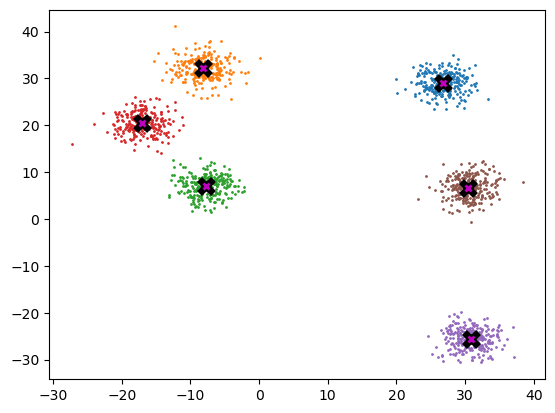

In [20]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

均值漂移聚类确实是一个强大的聚类算法，具有一些重要的优势，正如您所指出的那样。以下是其一些关键特点的简要概述：

无需预先指定聚类数量：与k均值不同，均值漂移聚类不需要您事先指定聚类数量。相反，它根据数据点的密度自动确定聚类数量。

带宽参数：均值漂移聚类需要您指定一个带宽参数。该参数确定用于每个数据点周围密度估计的区域大小。虽然您需要选择此参数，但通常可以使用诸如交叉验证等技术来自动选择。

适应不同的聚类形状：均值漂移聚类可以检测任何形状的聚类，

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [21]:
midp = data.mean(0)
midp

tensor([ 9.199, 11.704])

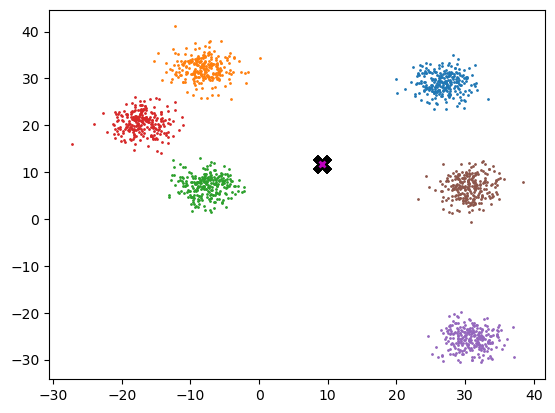

In [23]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [24]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [25]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

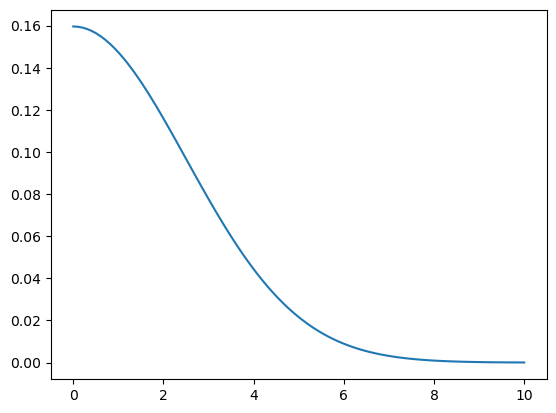

In [26]:
plot_func(partial(gaussian, bw=2.5))

In [27]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [28]:
def tri(d, i): return (-d+i).clamp_min(0)/i

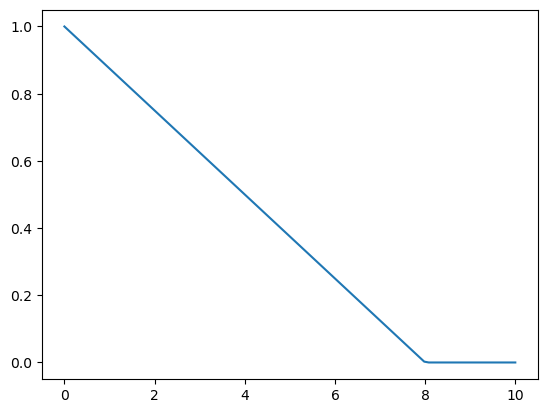

In [29]:
plot_func(partial(tri, i=8))

In [30]:
X = data.clone()
x = data[0]

In [31]:
x

tensor([22.469, 32.467])

In [32]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [33]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [-6.706,  3.741],
        [-5.316,  5.761],
        [-6.534, -1.591],
        [-3.735,  0.234],
        [-8.000,  6.090],
        [-1.964,  7.416],
        [-2.463,  4.510]])

In [34]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [-6.706,  3.741],
        [-5.316,  5.761],
        [-6.534, -1.591],
        [-3.735,  0.234],
        [-8.000,  6.090],
        [-1.964,  7.416],
        [-2.463,  4.510]])

In [35]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([ 0.000,  7.679,  7.839,  6.725,  3.742, 10.054,  7.671,  5.138])

In [36]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.001,     0.001,  ...,     0.000,     0.000,     0.000])

In [37]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [38]:
weight[:,None].shape

torch.Size([1500, 1])

In [39]:
weight[:,None]*X

tensor([[    3.586,     5.181],
        [    0.042,     0.041],
        [    0.032,     0.031],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [40]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [41]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [42]:
%time X=meanshift(data)

CPU times: total: 1.02 s
Wall time: 1.12 s


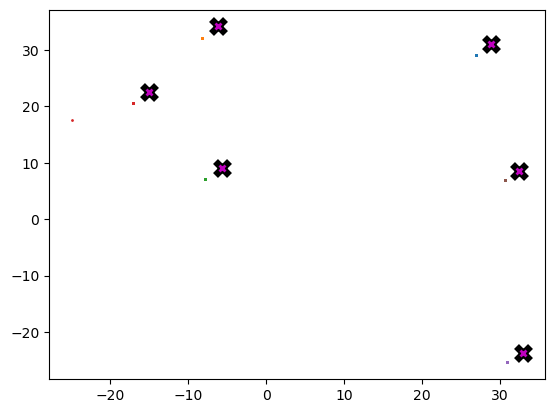

In [43]:
plot_data(centroids+2, X, n_samples)

## Animation

In [44]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [45]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [46]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [47]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [48]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

这个函数 dist_b(a, b) 用来计算两组点 a 和 b 之间的欧几里得距离。让我解释一下它的工作原理：

(a[None]-b[:,None])**2：这一步首先计算了每对点之间的差值的平方。a[None] 创建了一个新的维度，将 a 变为形状为 (1, a_dim) 的数组。而 b[:, None] 创建了另一个新的维度，将 b 变为形状为 (b_dim, 1) 的数组。然后，对应位置上的差值被计算，并且每个差值都被平方。

.sum(2)：这一步对平方差值沿着第三个维度（即轴为2的维度，Python中从0开始计数）进行求和。因为我们对每个点对的平方差值进行了计算，所以轴2上的求和操作会得到每个点对的欧几里得距离的平方。

.sqrt()：最后，对求和后的结果取平方根，得到了每对点之间的欧几里得距离。

这个函数能够高效地计算两组点之间的距离，对于聚类算法等需要频繁地计算点之间距离的任务非常有用。

In [49]:
dist_b(X, x)

tensor([[ 0.000,  7.679,  7.839,  ..., 29.253, 28.221, 28.493],
        [ 7.679,  0.000,  2.452,  ..., 24.478, 23.924, 24.365],
        [ 7.839,  2.452,  0.000,  ..., 22.571, 21.885, 22.288],
        [ 6.725,  5.335,  7.453,  ..., 29.813, 29.247, 29.678],
        [ 3.742,  4.597,  5.749,  ..., 28.254, 27.478, 27.843]])

In [50]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [ ]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

(X[None,:]-x[:,None]).shape：前两个张量经过广播操作扩展为相同的形状，然后进行相减操作。因为两个张量的形状都是 (5, 1500, 2)，所以相减的结果形状也是 (5, 1500, 2)。

In [51]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.000,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.199,     0.094,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.094,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.006,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.014,     0.003,  ...,     0.000,     0.000,     0.000]])

因此，假设 gaussian 函数是一个将距离矩阵和方差作为输入的函数，它将返回一个形状与输入距离矩阵相同的张量，其中每个元素表示对应距离的高斯函数值。

In [52]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [53]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [54]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [55]:
num

tensor([[102.964, 131.319],
        [465.394, 479.626],
        [424.768, 433.243],
        [118.419, 133.504],
        [321.881, 373.033]])

In [56]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[102.964, 131.319],
        [465.394, 479.626],
        [424.768, 433.243],
        [118.419, 133.504],
        [321.881, 373.033]])

In [57]:
weight@X

tensor([[102.964, 131.319],
        [465.394, 479.626],
        [424.768, 433.243],
        [118.419, 133.504],
        [321.881, 373.033]])

In [59]:
div = weight.sum(1, keepdim=True)
div

tensor([[ 4.232],
        [16.559],
        [15.575],
        [ 4.212],
        [12.133]])

In [60]:
num/div

tensor([[24.329, 31.029],
        [28.105, 28.964],
        [27.272, 27.816],
        [28.117, 31.698],
        [26.530, 30.746]])

In [61]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [62]:
data = data.cuda()

In [63]:
X = meanshift(data).cpu()

In [64]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

7.32 ms ± 978 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


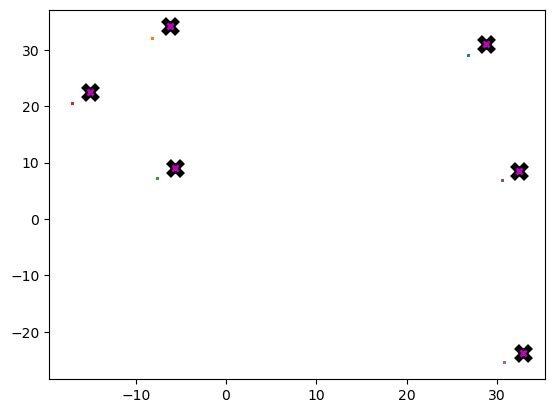

In [65]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

实现聚类算法或最近邻搜索算法在GPU上可以显著提高速度，因为GPU具有并行处理的能力。以下是您可能实现k均值聚类或快速最近邻算法的一般步骤：

选择GPU加速库：像cuML（RAPIDS的一部分）用于k均值聚类，cuML或Faiss用于快速最近邻搜索，cuML或cuGraph用于DBSCAN等库可以使用。这些库经过了GPU执行的优化，并且相比于CPU版本，能够提供显著的加速效果。

数据准备：将数据加载到GPU内存中，并确保其适合GPU计算的格式。这可能涉及将数据转换为GPU张量或使用特定的GPU数据结构。

实现算法：根据选择的算法，在GPU上实现相应的逻辑。对于k均值聚类，您需要实现初始化聚类中心、分配数据点到最近的聚类中心和更新聚类中心的步骤。对于最近邻搜索，您需要实现有效的搜索算法来找到最近邻的数据点。

性能比较：实现GPU版本后，进行性能比较，与纯Python或CPU版本进行比较，以验证GPU版本是否更快。您可以使用时间分析工具来测量算法的执行时间，并比较不同版本之间的性能差异。

优化和调试：根据性能比较结果进行优化和调试，以确保GPU版本的算法达到最佳性能。

对于APL版本，您可以尝试使用APL的向量化和并行化特性来实现相同的算法。APL通常提供了丰富的数组操作和函数，使得实现算法变得更加简洁和高效。